In [1]:
from __future__ import unicode_literals, print_function, division

import glob
import os
import random
import time
import math
import torch
import torchvision
import unicodedata
import string

import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms

from io import open
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [2]:
# Build the language_words dictionary, a list of words per language
def parseCSV(file):
    """returns pandas dataframe from CSV file"""
    data = pd.read_csv(file)
    return data

def reformatData(data):
    """takes in pandas dataframe and outputs data in right format"""
    language_words = defaultdict(list) 
    data = data.to_dict('split')['data']
    
    for entry in data:
        language_words[entry[1]].append(entry[0])
        
    return dict(language_words)

csv_data = parseCSV('language_dataset.csv')
train_data, test_data = train_test_split(csv_data, test_size=0.2)

training_words = reformatData(train_data)
testing_words = reformatData(test_data)

all_languages = list(training_words.keys())
n_languages = len(all_languages)

Parse our language dataset and populate four variables we will be using later:

training_words = `{'Simlish': ['Dag Dag', 'Zagadoo', ...], 'English': ['event', ..], ...}`

test_words = same format at training_words

all_languages = `['English', 'Spanish', 'Tolkien Elvish', ...]`

n_languages = 7

In [3]:
# populate all_letters with alphabet lower and upper 
# along with spaces and a few other punctuations
all_letters = set()

for letter in string.ascii_letters + " .,;'" + 'áéíóúüñàèìòùçâêîôûëïäöß()-āēīōū’ā̆ē̆ī̆ō̆ăĭḗū́u̯ṇ̃þʒ¹²/':
    all_letters.add(letter)

# we also need to include special characters found in certain languages
# primarily Tolkien Elvish and Spanish
for lang in training_words.keys():
    for word in training_words[lang]:
        for letter in word:
            all_letters.add(letter)
            
for lang in testing_words.keys():
    for word in testing_words[lang]:
        for letter in word:
            all_letters.add(letter)      
            
n_letters = len(all_letters)
all_letters = sorted(list(all_letters))
print('n_letters:', n_letters)
print('all_letters:', all_letters)

n_letters: 112
all_letters: [' ', "'", '(', ')', ',', '-', '.', '/', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '²', '¹', 'Ä', 'Ö', 'Ü', 'ß', 'à', 'á', 'â', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'þ', 'ā', 'ă', 'ē', 'ĕ', 'ī', 'ĭ', 'ō', 'ŏ', 'œ', 'ū', 'ƀ', 'ʒ', 'ˢ', '́', '̆', '̣', '̯', 'ṃ', 'ṇ', '’', '…']


In [4]:
# Turn names into tensors
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    try:
        if letter == '\xa0':
            letter = ' '
        return all_letters.index(letter)
    except:
        return None

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [5]:
# Turn a line into a <line_length x 1 x n_letters> tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    language_i = top_i[0].item()
    return all_languages[language_i], language_i

In [6]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_languages) # choose a random language
    line = randomChoice(training_words[category]) # choose a random word from that language
    # turn the language into a 1D tensor
    category_tensor = torch.tensor([all_languages.index(category)], dtype=torch.long)
    # line_tensor is a 2D tensor containing a tensor for each letter
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        # Put the declaration of RNN network here
        self.hidden_size = hidden_size
    
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Put the computation for forward pass here
        combined = torch.cat((input, hidden), 1)
        output = self.i2o(combined)
        output = self.softmax(output)
        hidden = self.i2h(combined)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_languages)

In [9]:
def train_iteration_CharRNN(learning_rate, category_tensor, line_tensor):
    criterion = nn.NLLLoss()
    hidden = rnn.initHidden()
    rnn.zero_grad()

    # The forward process
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # The backward process
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


In [10]:
def train_charRNN(n_iters, learning_rate):
    print_every = 1000
    current_loss = 0
    losses = []

    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train_iteration_CharRNN(learning_rate, category_tensor, line_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (
                iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
            print('Average loss: %.4f' % (current_loss/print_every))
            losses.append(current_loss/print_every)
            current_loss = 0

    torch.save(rnn, 'char-rnn-classification.pt')
    return losses

In [11]:
# Finish the prediction function to provide predictions for any 
# input string (name) from the user
def predict(input_line, n_predictions=7):
#     print("Prediction for %s:" % input_line)
    hidden = rnn.initHidden()

    # Generate the input for RNN
    line_tensor = lineToTensor(input_line)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Get the value and index of top K predictions from the output
    # Then apply Softmax function on the scores of all category predictions so we can 
    # output the probabilities that this name belongs to different languages.
    topv, topi = output.data.topk(n_predictions, 1, True)
    softmax = nn.Softmax(dim=1)
    top_prob = softmax(topv)
    predictions = []
 
    for i in range(3):
        value = topv[0][i]
        prob = top_prob[0][i] * 100
        category_index = topi[0][i]
#         print('%s Probability: (%.2f), Score: (%.2f)' % (all_languages[category_index], prob, value))
        predictions.append([value, all_languages[category_index]])
    return predictions

In [12]:
losses = train_charRNN(10000, 0.02)

1000 10% (0m 6s) 1.6049 caminar / English ✗ (Spanish)
Average loss: 1.8484
2000 20% (0m 11s) 1.5549 controllare / French ✗ (Italian)
Average loss: 1.6648
3000 30% (0m 16s) 1.9913 stampa / Tolkien Elvish ✗ (Italian)
Average loss: 1.5062
4000 40% (0m 22s) 1.3368 venire / French ✗ (Italian)
Average loss: 1.4634
5000 50% (0m 27s) 2.0038 boutique / Simlish ✗ (French)
Average loss: 1.3270
6000 60% (0m 32s) 1.0491 autre / French ✓
Average loss: 1.2801
7000 70% (0m 37s) 0.8360 morokō / Tolkien Elvish ✓
Average loss: 1.1987
8000 80% (0m 42s) 0.8655 guerra / Italian ✓
Average loss: 1.1608
9000 90% (0m 48s) 1.0197 massa / Spanish ✗ (Italian)
Average loss: 1.1610
10000 100% (0m 52s) 1.2112 suffixe / French ✓
Average loss: 1.0866


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1.848379092335701, 1.6647886455655099, 1.5061874838471412, 1.4634344609379768, 1.3269642677009106, 1.2801008117515593, 1.1986933440165595, 1.1607627600552515, 1.1610006441567093, 1.0866014264065307]


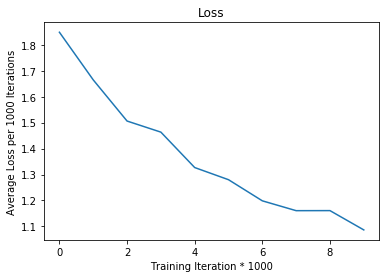

In [13]:
print(losses)
plt.plot(losses)
plt.xlabel('Training Iteration * 1000')
plt.ylabel('Average Loss per 1000 Iterations')
plt.title('Loss')
plt.show()

In [14]:
def getAccuracy(dataset):
    total_words = len(dataset.index)
    correct_predictions = 0
    for i in dataset.index:
        word = dataset['Word'][i]
        language = dataset['Language'][i]
        prediction = predict(word)[0][1]
        if prediction == language:
            correct_predictions += 1
    return correct_predictions / total_words

In [15]:
print('training data accuracy: {:.4f}%'.format(getAccuracy(train_data) * 100))
print('testing data accuracy: {:.4f}%'.format(getAccuracy(test_data) * 100))

training data accuracy: 60.4129%
testing data accuracy: 57.0018%
